In [16]:
!pip install guppy3

## Import modules

In [62]:
import numpy as np

# to get and read data
import os
from scipy.io import loadmat

# to plot the data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [78]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/project")
from common_modules import data_f, network_f, patches_f, clusters_f
from char_modules import preprocess_f, plotting_f

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import importlib
importlib.reload(plotting_f)

<module 'char_modules.plotting_f' from '/content/drive/MyDrive/project/char_modules/plotting_f.py'>

## get and read data

get data

In [23]:
data_f.download_file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat",
                        saveAs = "mixoutALL_shifted.mat")

#load the file
mat = loadmat('mixoutALL_shifted.mat')
print(mat.keys())

file already exists
dict_keys(['__header__', '__version__', '__globals__', 'consts', 'mixout'])


read data

In [24]:
consts = mat['consts'][0][0]
#print(consts)

classes = [char[0] for char in consts[3][0]]
print(classes)
print('number of classes :',len(classes))

#subtract 1 since np array indexing is from 0
labels = consts[4][0] - 1
inputs = mat['mixout'][0]

train_inputs, test_inputs, train_labels, test_labels = data_f.train_test_split(inputs, labels, test_size=0.25, random_state=0)

# align train_data and test_data lengths
def append_defaults(series, target=None, default=0):
    if target is None:
        target = np.max([len(d[0]) for d in series])
    result = []
    for d in series:
        tmp = np.zeros((d.shape[0], target))
        for i, c in enumerate(d):
            tmp[i, :len(c)] = c
        result.append(tmp)
    return np.array(result), target

train_inputs, target_len = append_defaults(train_inputs)
test_inputs, _ = append_defaults(test_inputs, target_len)

train_data = list(zip(train_inputs, train_labels))
test_data = list(zip(test_inputs, test_labels))

['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']
number of classes : 20


max length = 205


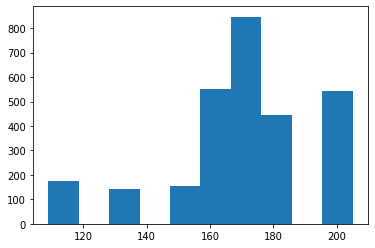

In [25]:
# distribution of sample lenghts
lengths = []

for sample in inputs:
  input = sample[0]
  input = np.array(input)
  lengths.append(len(input))

print('max length =',np.max(lengths))
_ = plt.hist(lengths)


## patches

In [26]:
from tqdm.notebook import tqdm
# function to return list of patches for a given dataset
def dataToPatches_new(data, window_size, stride):
  inputs, labels, indexes = [], [], []

  for index,(inpu,label) in enumerate(tqdm(data)):
    inputLen = len(inpu[0])
    
    for i in range(0, inputLen, stride):
      channels = []
      # verify if last stride is possible
      if i + window_size in range(inputLen + 1):
        for channel in inpu:
          values  = [0]*i
          values += list(channel)[i:i+window_size]
          values += [0]*(inputLen - i - window_size)
          
          indicator  = [0]*i
          indicator += [1]*window_size
          indicator += [0]*(inputLen - i - window_size)
          channels.append(values)
          
        channels.append(indicator)

        inputs.append(channels)
        labels.append(label)
        indexes.append(index)

  return np.array(inputs), np.array(labels, dtype=int), np.array(indexes)

kwargs = {'window_size':20, 'stride':10}
kwargs['data'] = train_data
train_inputs, train_labels, train_indexes = dataToPatches_new(**kwargs)
kwargs['data'] = test_data
test_inputs, test_labels, test_indexes = dataToPatches_new(**kwargs)

In [ ]:
'''kwargs = {'window_size':20, 'stride':10}#, 'resizeTo':20, "normalize":(-1,1)}

kwargs['data'] = train_data
train_inputs, train_labels, train_indexes = patches_f.dataToPatches(**kwargs)
kwargs['data'] = test_data
test_inputs, test_labels, test_indexes = patches_f.dataToPatches(**kwargs)'''

create dataset and dataloader

In [ ]:
train_loader, val_loader, test_loader = data_f.createLoaders(train_inputs, train_labels,
                                                                  test_inputs, test_labels,
                                                                  batch_size=32)

### visualize patches

a
original sample


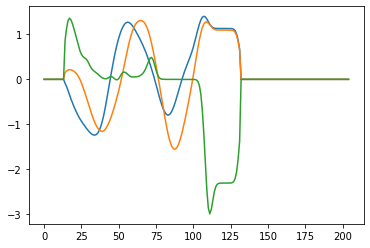

19 patches


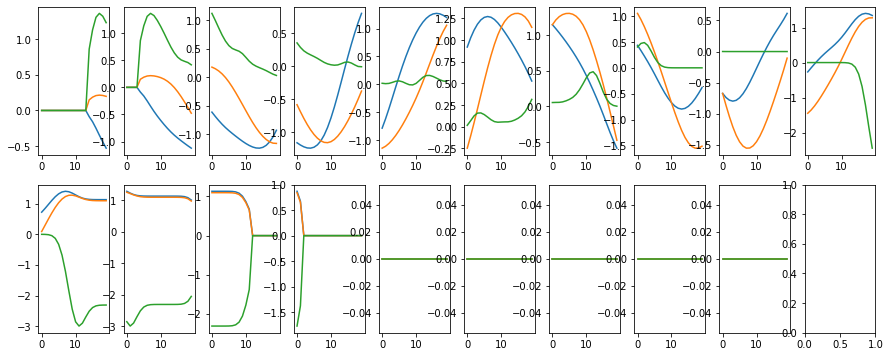

In [80]:
plotting_f.plotTimeSeries(train_data, train_indexes, train_inputs, char='a', index=0)

a
original sample


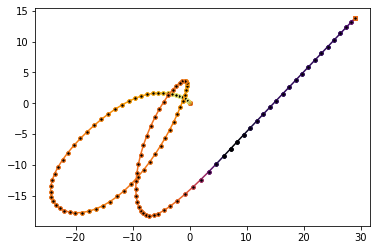

19 patches


/content/drive/MyDrive/project/char_modules/plotting_f.py:19: RuntimeWarning: invalid value encountered in true_divide
  color = (force - np.min(force)) / (np.max(force)-np.min(force))


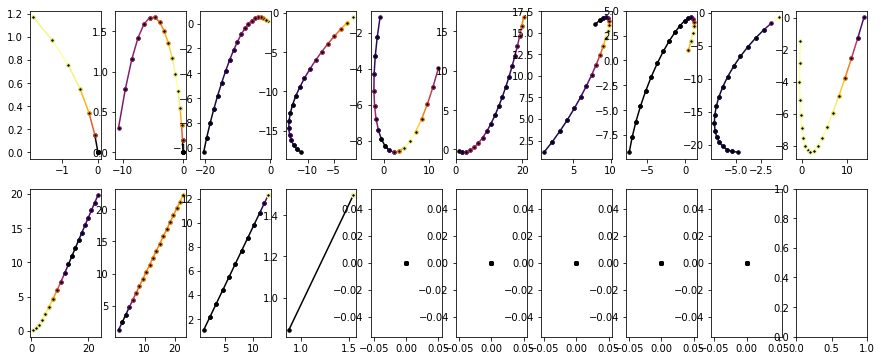

In [75]:
plotting_f.plotChar(train_data, train_indexes, train_inputs, char='a', index=0)

## clustering

In [ ]:
# flatten inputs to 2d array
nsamples, nx, ny = train_inputs.shape
sample_shape = nx, ny
train_inputs2d = train_inputs.reshape((nsamples,nx*ny))

### using scikit

plot silhoutte index for number of cluster 2 to 21


runtime:  4619.861713647842

memory consumption:
Partition of a set of 774533 objects. Total size = 455608441 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   3200   0 358315349  79 358315349  79 numpy.ndarray
     1 209977  27 30695785   7 389011134  85 str
     2 205456  27 16482264   4 405493398  89 tuple
     3  85481  11  6905099   2 412398497  91 bytes
     4  43547   6  6302112   1 418700609  92 types.CodeType
     5  40918   5  5564848   1 424265457  93 function
     6  13710   2  5222032   1 429487489  94 dict (no owner)
     7   4826   1  4789272   1 434276761  95 type
     8   2127   0  3127960   1 437404721  96 dict of module
     9   4826   1  2540856   1 439945577  97 dict of type
<1748 more rows. Type e.g. '_.more' to view.>



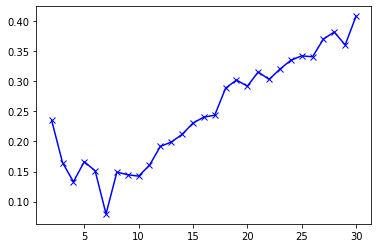

 n_clusters  silhouette      cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.235026  3017.100372   2.196952  0.000960     0.010816   0.010956    0.207936
          3    0.164824  2948.814726   2.211393  0.002671     0.020436   0.020688    0.187951
          4    0.132977  2976.645622   2.227971  0.004847     0.023733   0.024076    0.164276
          5    0.166398  2963.983549   2.252780  0.010050     0.035263   0.035690    0.156365
          6    0.151103  2911.027271   2.011092  0.010297     0.043278   0.043788    0.147741
          7    0.079501  2914.426489   2.051750  0.012615     0.046603   0.047188    0.135943
          8    0.149058  2995.438583   1.935959  0.012703     0.045555   0.046211    0.123652
          9    0.144673  2871.602128   1.861532  0.014868     0.057627   0.058364    0.129498
         10    0.142328  2801.416299   1.813801  0.013245     0.045850   0.046654    0.112865
         11    0.160579  2818.421480   1.822056  0.015252   

In [81]:
_ = clusters_f.form_clusters(train_inputs2d, "KMeans", list(range(2,31)), train_labels)#list(range(2,22))


runtime:  6632.2175941467285

memory consumption:
Partition of a set of 881890 objects. Total size = 255694521 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   3202   0 145364781  57 145364781  57 numpy.ndarray
     1 259838  29 36073076  14 181437857  71 str
     2 224066  25 17800352   7 199238209  78 tuple
     3  92638  11  7343231   3 206581440  81 bytes
     4  47148   5  6822136   3 213403576  83 types.CodeType
     5  17291   2  6207560   2 219611136  86 dict (no owner)
     6  44521   5  6054856   2 225665992  88 function
     7   5653   1  5509592   2 231175584  90 type
     8   2353   0  3401800   1 234577384  92 dict of module
     9   5653   1  2884056   1 237461440  93 dict of type
<2254 more rows. Type e.g. '_.more' to view.>



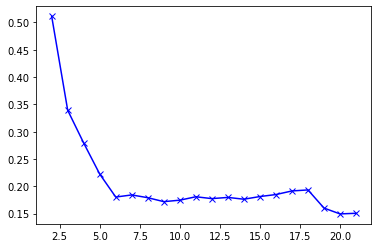

 n_clusters  silhouette       cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.511452  60296.289303   0.705493  0.002436     0.009207   0.009361    0.167481
          3    0.339315  42403.274547   0.964584  0.003250     0.017651   0.017937    0.156858
          4    0.279211  38470.236047   1.179686  0.011898     0.041634   0.042020    0.143506
          5    0.222397  31950.692297   1.708382  0.021216     0.053462   0.053936    0.130828
          6    0.180313  27621.483043   1.824683  0.021917     0.059147   0.059712    0.120895
          7    0.184173  24284.335038   1.755266  0.023450     0.064394   0.065050    0.116702
          8    0.179112  21676.037135   1.848024  0.026927     0.069643   0.070382    0.111736
          9    0.171871  19584.824690   2.029033  0.026594     0.075853   0.076675    0.107630
         10    0.174561  17985.634120   1.990475  0.027951     0.084621   0.085527    0.107566
         11    0.180842  16726.144177   2.047831  

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "AgglomerativeClustering", list(range(2,22)), train_labels)


runtime:  4937.640772342682

memory consumption:
Partition of a set of 766291 objects. Total size = 454097386 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   3200   0 357543699  79 357543699  79 numpy.ndarray
     1 205356  27 30399659   7 387943358  85 str
     2 204939  27 16453408   4 404396766  89 tuple
     3  85568  11  6916536   2 411313302  91 bytes
     4  43618   6  6312336   1 417625638  92 types.CodeType
     5  40992   5  5574912   1 423200550  93 function
     6  13169   2  5013848   1 428214398  94 dict (no owner)
     7   4830   1  4792808   1 433007206  95 type
     8   2139   0  3127344   1 436134550  96 dict of module
     9   4830   1  2542352   1 438676902  97 dict of type
<1744 more rows. Type e.g. '_.more' to view.>



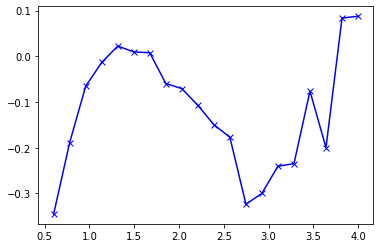

      eps  n_clusters  silhouette      cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
 0.600000         399   -0.344673    68.437880   1.384979  0.001123     0.261598   0.293386    0.164425
 0.778947         563   -0.188626    76.253041   1.439526  0.006987     0.351735   0.384002    0.130468
 0.957895         581   -0.065329   120.528850   1.434614  0.018820     0.408967   0.435968    0.105802
 1.136842         512   -0.013431   201.993534   1.477898  0.029635     0.421960   0.444241    0.092373
 1.315789         445    0.022245   297.871826   1.620373  0.040497     0.428469   0.447336    0.087152
 1.494737         383    0.009549   393.038924   1.591292  0.042815     0.402557   0.419771    0.084127
 1.673684         324    0.007603   500.332442   1.628895  0.044478     0.388648   0.403718    0.082862
 1.852632         239   -0.059562   595.172566   1.775006  0.039819     0.354466   0.366998    0.083717
 2.031579         185   -0.070642   648.220691   1.825090  0.031

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "DBSCAN", np.linspace(0.6,4,20) , train_labels)

### using clusteval

In [ ]:
! pip install clusteval
from clusteval import clusteval

In [ ]:
ce = clusteval(cluster='kmeans', method='silhouette', max_clust=20)
ce.fit(train_inputs2d)

  0%|          | 0/18 [00:00<?, ?it/s]


[clusteval] >Fit using kmeans with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 18/18 [18:48<00:00, 62.72s/it]

[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


{'fig': {'clustcutt': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19]),
  'sillclust': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16., 17., 18., 19.]),
  'silscores': array([0.54193945, 0.37888295, 0.31563263, 0.25609774, 0.21650868,
         0.21577832, 0.20465675, 0.20050424, 0.20050938, 0.20122135,
         0.19515922, 0.2051068 , 0.20111758, 0.20939407, 0.1726051 ,
         0.22036442, 0.22207266, 0.17577018])},
 'labx': array([ 0, -1, -1, ..., -1,  0,  0], dtype=int32),
 'max_d': None,
 'max_d_lower': None,
 'max_d_upper': None,
 'method': 'silhouette',
 'score':     clusters     score
 0          2  0.541939
 1          3  0.378883
 2          4  0.315633
 3          5  0.256098
 4          6  0.216509
 5          7  0.215778
 6          8  0.204657
 7          9  0.200504
 8         10  0.200509
 9         11  0.201221
 10        12  0.195159
 11        13  0.205107
 12        14  0.201118
 13    

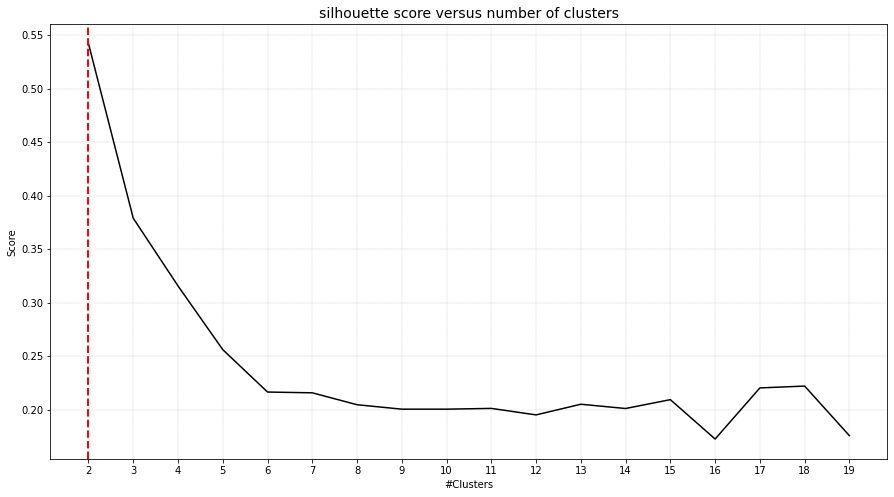

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4537f5b828>)

In [ ]:
ce.plot()

In [ ]:
ce = clusteval(cluster='kmeans', method='silhouette', metric="jaccard", max_clust=20)
ce.fit(train_inputs2d)


  0%|          | 0/18 [00:00<?, ?it/s]


[clusteval] >Fit using kmeans with metric: jaccard, and linkage: ward
[clusteval] >Evaluate using silhouette.



100%|██████████| 18/18 [19:11<00:00, 63.95s/it]

[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


{'fig': {'clustcutt': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19]),
  'sillclust': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16., 17., 18., 19.]),
  'silscores': array([0.54193945, 0.37888295, 0.31565633, 0.25609774, 0.21649568,
         0.2125702 , 0.20465735, 0.20051259, 0.20048024, 0.19256196,
         0.20288043, 0.20807075, 0.2130675 , 0.17395119, 0.1694204 ,
         0.17639431, 0.17678397, 0.1782589 ])},
 'labx': array([-1,  0,  0, ...,  0, -1, -1], dtype=int32),
 'max_d': None,
 'max_d_lower': None,
 'max_d_upper': None,
 'method': 'silhouette',
 'score':     clusters     score
 0          2  0.541939
 1          3  0.378883
 2          4  0.315656
 3          5  0.256098
 4          6  0.216496
 5          7  0.212570
 6          8  0.204657
 7          9  0.200513
 8         10  0.200480
 9         11  0.192562
 10        12  0.202880
 11        13  0.208071
 12        14  0.213067
 13    

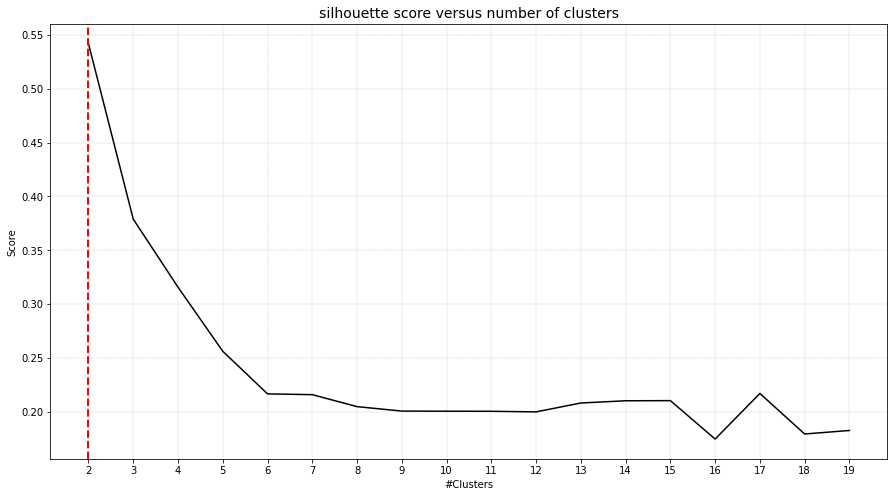

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1d40d2ab38>)

In [ ]:
ce.plot()

In [ ]:
ce = clusteval(cluster="agglomerative", method="dbindex" , max_clust=20)
ce.fit(train_inputs2d)


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward



  0%|          | 0/18 [00:00<?, ?it/s]

[clusteval] >Evaluate using dbindex.



100%|██████████| 18/18 [00:11<00:00,  1.63it/s]

[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [19].
[clusteval] >Fin.


{'fig': {'clustcutt': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19]),
  'dbclust': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16., 17., 18., 19.]),
  'scores': array([0.35274648, 0.33219088, 0.33948757, 0.45937565, 0.38281304,
         0.28835274, 0.27787911, 0.28653259, 0.25787933, 0.23443576,
         0.21489944, 0.21473387, 0.19939574, 0.18610269, 0.17447127,
         0.1499802 , 0.14164796, 0.13419281])},
 'labx': array([13,  4, 11, ...,  6, 15, 15], dtype=int32),
 'max_d': 158.75346176725884,
 'max_d_lower': 157.66385116040044,
 'max_d_upper': 159.84307237411727,
 'method': 'dbindex',
 'score':     clusters     score
 0          2  0.352746
 1          3  0.332191
 2          4  0.339488
 3          5  0.459376
 4          6  0.382813
 5          7  0.288353
 6          8  0.277879
 7          9  0.286533
 8         10  0.257879
 9         11  0.234436
 10        12  0.214899
 11        13  0.2147

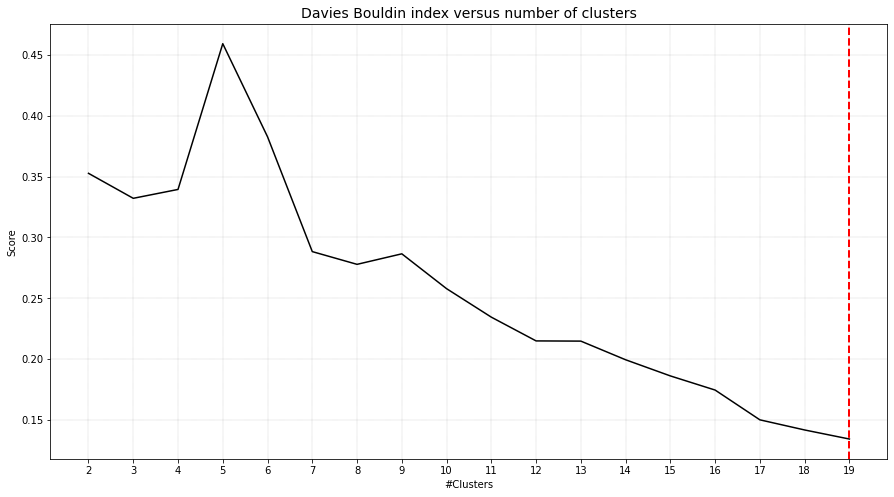

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1d40bcfdd8>)

In [ ]:
ce.plot()

In [ ]:
ce = clusteval(cluster="agglomerative", method="silhouette" , max_clust=20)
ce.fit(train_inputs2d)


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward



  0%|          | 0/18 [00:00<?, ?it/s]

[clusteval] >Evaluate using silhouette.



100%|██████████| 18/18 [12:40<00:00, 42.26s/it]

[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


{'fig': {'clustcutt': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19]),
  'sillclust': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16., 17., 18., 19.]),
  'silscores': array([0.51145197, 0.33931459, 0.2792111 , 0.22239699, 0.18031306,
         0.18417292, 0.1791121 , 0.17187081, 0.17456094, 0.18084198,
         0.17742515, 0.17963129, 0.17633802, 0.18124202, 0.18488484,
         0.19149603, 0.1933416 , 0.16013296])},
 'labx': array([1, 0, 0, ..., 0, 1, 1], dtype=int32),
 'max_d': 1663.097849494531,
 'max_d_lower': 842.149429307909,
 'max_d_upper': 2484.046269681153,
 'method': 'silhouette',
 'score':     clusters     score
 0          2  0.511452
 1          3  0.339315
 2          4  0.279211
 3          5  0.222397
 4          6  0.180313
 5          7  0.184173
 6          8  0.179112
 7          9  0.171871
 8         10  0.174561
 9         11  0.180842
 10        12  0.177425
 11        13  0.179631

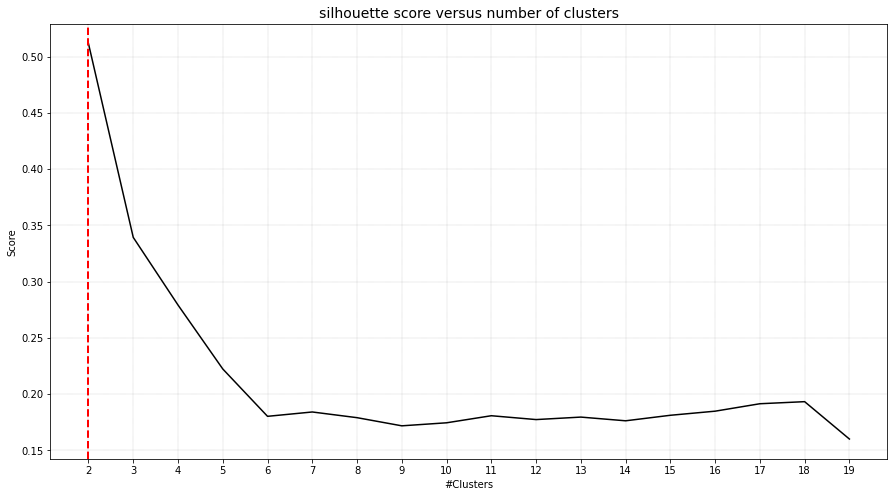

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1d40adeeb8>)

In [ ]:
ce.plot()

### visualize cluster centers


runtime:  174.01248502731323

memory consumption:
Partition of a set of 1032289 objects. Total size = 465621484 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   3200   0 357903185  77 357903185  77 numpy.ndarray
     1 209383  20 30631528   7 388534713  83 str
     2 204972  20 16445600   4 404980313  87 tuple
     3 262569  25  8402208   2 413382521  89 numpy.float64
     4  85449   8  6896103   1 420278624  90 bytes
     5  43543   4  6301536   1 426580160  92 types.CodeType
     6  40933   4  5566888   1 432147048  93 function
     7  13401   1  5105408   1 437252456  94 dict (no owner)
     8   4826   0  4789440   1 442041896  95 type
     9  11557   1  3892472   1 445934368  96 list
<1751 more rows. Type e.g. '_.more' to view.>

 n_clusters  silhouette      cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
         20    0.321838  2727.104273   1.491662  0.016776     0.073697   0.075092    0.070734

cluster centers visualize

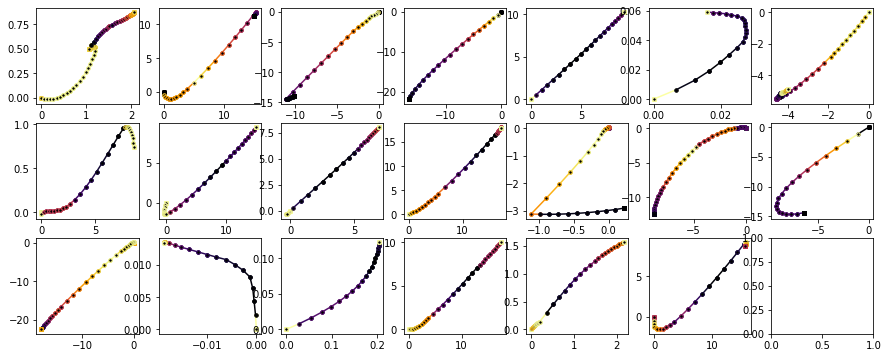

In [ ]:
cluster_centers = clusters_f.form_clusters(train_inputs2d, "KMeans", [20], train_labels)

print("\ncluster centers visualized")
plotting_f.plotClusters(cluster_centers, sample_shape)

## neural network

### define network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(368, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### create network

In [ ]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 2.028, val loss: 2.011
epoch: 30, train loss: 1.142, val loss: 1.257
epoch: 45, train loss: 0.802, val loss: 0.966
epoch: 60, train loss: 0.648, val loss: 0.821
epoch: 75, train loss: 0.561, val loss: 0.805
epoch: 90, train loss: 0.499, val loss: 0.781
epoch: 105, train loss: 0.450, val loss: 0.794
epoch: 120, train loss: 0.411, val loss: 0.825
epoch: 135, train loss: 0.375, val loss: 0.812
epoch: 150, train loss: 0.351, val loss: 0.895

Finished Training


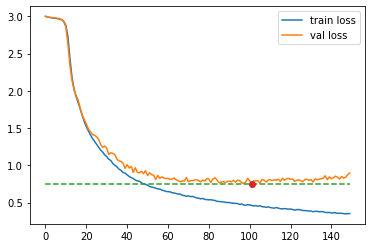

In [ ]:
best_params = network_f.trainNet(net,criterion,optimizer, 
                                  train_loader,val_loader,
                                  epochs=150)

In [ ]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [ ]:
print("evaluation results on train data")
network_f.evaluate(net,train_loader,classes)
print("evaluation results on test data")
network_f.evaluate(net,test_loader,classes)

evaluation results on train data



              precision    recall  f1-score   support

           a     0.8678    0.8553    0.8615       760
           b     0.7474    0.7978    0.7717       623
           c     0.9740    0.9920    0.9829       377
           d     0.8150    0.7972    0.8060       641
           e     0.9721    0.9650    0.9685       686
           g     0.7415    0.8132    0.7757       589
           h     0.7579    0.7214    0.7392       499
           l     0.9973    0.9945    0.9959       365
           m     0.8674    0.9525    0.9080       611
           n     0.8711    0.6414    0.7388       474
           o     0.9696    0.8531    0.9076       524
           p     0.7929    0.7737    0.7832       579
           q     0.8696    0.9539    0.9098       629
           r     0.7505    0.7427    0.7466       478
           s     0.8981    0.9706    0.9330       545
           u     0.7475    0.7078    0.7271       527
           v     0.9564    0.9844    0.9702       513
           w     0.6732   


              precision    recall  f1-score   support

           a     0.7751    0.7270    0.7503      1000
           b     0.6251    0.7090    0.6644       842
           c     0.9237    0.9453    0.9344       512
           d     0.7244    0.7421    0.7331       857
           e     0.9347    0.8900    0.9118       900
           g     0.6005    0.6167    0.6085       780
           h     0.6203    0.6052    0.6127       656
           l     0.9874    0.9593    0.9731       491
           m     0.7709    0.8165    0.7931       812
           n     0.6695    0.4750    0.5558       661
           o     0.8922    0.8112    0.8498       694
           p     0.6635    0.6403    0.6517       770
           q     0.7709    0.9077    0.8337       834
           r     0.5967    0.5550    0.5751       645
           s     0.8566    0.9367    0.8949       727
           u     0.5978    0.5905    0.5941       735
           v     0.9220    0.9636    0.9423       687
           w     0.5345   